# Populating dark matter haloes with HOD models

We are going to populate the millimil dark matter haloes with a halo occupation distribution (HOD) model, using [halotools](http://halotools.readthedocs.io/en/latest/overview.html#halotools-science-overview). The millimil has been run in a cubic box of comovin side of $62.5 {\rm Mpc}/h$ with dark matter particles with a minnimum mass of $0.86*10^9 {\rm M}_{\odot}/h$. The assumed cosmological parameters in this simulation are: $\Omega_0 = 0.25$, $\Lambda _0 = 0.75$, $\Omega _b = 0.045$ and $h_0 = 0.73$. 

Halotools is written in python and the source code is available in [github](https://github.com/astropy/halotools). The easiest way to install it is through 'pip' or 'conda'. If you install it fresh and encounter a problem related to the C compilers try: "sudo apt-get install python-dev". 

The steps we are going to follow are: 1) Get dark matter haloes at one redshift, 2) Choose an HOD model and 3) Populate the dark matter haloes with galaxies, following the chosen HOD model.

Note that halotools does not work on the jupyter notebook, so the corresponding code is quoted so you can copy and paste it on a script.

In [17]:
import numpy as np
import eagleSqlTools as sql
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os.path
%matplotlib notebook

## Dark matter haloes

#### Q.1 Using a SQL query download from the millimil table [MPAHalo](http://galaxy-catalogue.dur.ac.uk:8080/Millennium/Help?page=databases/millimil/mpahalo) the following properties of haloes at $z=0$: positions, peculiar velocities, number of particles, mass,  the half mass radius of the halo, the maximum rotational velocity of the halo, the unique ID of the halo and the id of the halo at the center of the friend-of-friends group to which this halo belongs. 

Let's have a look to the distribution of download haloes in the simulation box.

0.00123051460832 62.4997062683 0.000606290181167 62.4988937378 0.00131582748145 62.4995422363


<IPython.core.display.Javascript object>


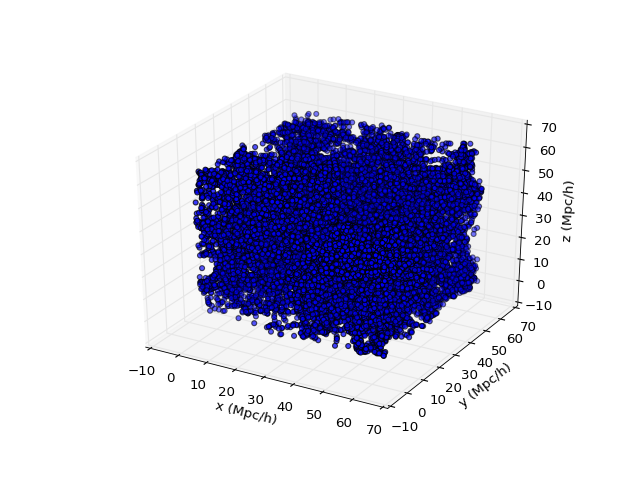

In [18]:
# Read the file with halo information we have downloaded:
x,y,z = np.loadtxt('haloes_mpahalo_z0.dat',usecols=(0,1,2),unpack=True)
print min(x),max(x),min(y),max(y),min(z),max(z)

# Plot
fig = plt.figure(1) ; ax = fig.add_subplot(111,projection='3d')
xtit ='x (Mpc/h)' ; ytit ='y (Mpc/h)'; ztit ='z (Mpc/h)'
ax.set_xlabel(xtit) ; ax.set_ylabel(ytit) ; ax.set_zlabel(ztit)
ax.scatter(xs=x,ys=y,zs=z)

The halo catalogue we have generated needs to be modify in order to be used by [halotos](http://halotools.readthedocs.io/en/latest/api/halotools.sim_manager.UserSuppliedHaloCatalog.html#halotools.sim_manager.UserSuppliedHaloCatalog). Below you have the python lines for halotools to use a halo catalogue stored in 'new_catalogue.txt'. In this catalogue the mass is in  $M_{\odot}h^{-1}$ units, 'ids' is an integer array and 'upid' is an integer array of zeros and -1 for those haloes at the center of the friend-of-friend group they belong to.

#### Q.2 Generate the 'new_catalogue.txt' file that can be used in the code below.  What are the keys in the halotools halo_catalog?

```python
    from halotools.sim_manager import UserSuppliedHaloCatalog

    xm, ym, zm, vx, vy, vz, \
        nparticles, mass, r50, vmax, ids, upids = np.loadtxt('new_catalogue.txt',unpack='True') 

    halo_catalog = UserSuppliedHaloCatalog(simname='millimil',\
                                       redshift = 0.0,\
                                       Lbox = 62.5,\
                                       particle_mass = 8.6e8,\
                                       halo_x = xm,\
                                       halo_y = ym,\
                                       halo_z = zm,\
                                       halo_vx = vx,\
                                       halo_vy = vy,\
                                       halo_vz = vz,\
                                       halo_rvir = r50,\
                                       halo_mvir = mass,\
                                       halo_id = ids,\
                                       halo_upid = upid)

    # The halo catalog itself is stored in the halo_table attribute, with columns accessed as follows
    halos = halo_catalog.halo_table
    print(halos.keys())
```

## HOD model

The probability of finding a certian type of galaxy hosted by a halo of a given mass can be established using semi-analytical and hydrodynamical models. Below you can find the code to get the mean halo occupation distribution (HOD) for all galaxies with masses M$>10^{10}M_{\odot}h^{-1}$ at redshift 0 for galaxies from the [De Lucia et al 2007](http://galaxy-catalogue.dur.ac.uk:8080/Millennium/Help?page=databases/millimil/delucia2006a) model, that has been used to populate the millimil dark matter haloes.

<IPython.core.display.Javascript object>


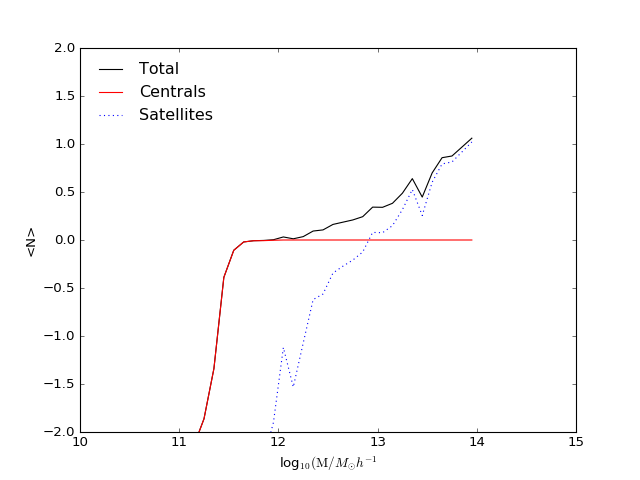

In [19]:
con = sql.connect("xyz", "abc", url="http://virgodb.dur.ac.uk:8080/Millennium")

the_query =""" select .1*(.5+floor((log10(h.m_Crit200)+10)/.1)) as logx, 
        SUM(CASE WHEN g.type=0 THEN 1 ELSE 0 END) as Haloes,
        SUM(CASE WHEN g.stellarmass > 1 THEN 1 ELSE 0 END) as Galaxies,
        SUM(CASE WHEN g.stellarmass > 1 AND g.type=0  THEN 1 ELSE 0 END) as Centrals,
        SUM(CASE WHEN g.stellarmass > 1 AND g.type!=0 THEN 1 ELSE 0 END) as Satellites
        from millimil..mpahalo h, millimil..DeLucia2006a g
        where g.redshift = 0. and h.m_Crit200 > 0. and h.haloID = g.haloID
        group by .1*(.5+floor((log10(h.m_Crit200)+10)/.1))
        order by .1*(.5+floor((log10(h.m_Crit200)+10)/.1)); """

data = con.execute_query(the_query)

# Discard bins with no haloes
inhaloes = data["Haloes"] ; ind = np.where(inhaloes>0.)
haloes = 1.*inhaloes[ind]
logx = data["logx"][ind]
tot = 1.*data["Galaxies"][ind]
cen = 1.*data["Centrals"][ind]
sat = 1.*data["Satellites"][ind]

# Plot
ytit ='<N>' ; xtit ='log$_{10}({\\rm M}/M_{\odot}h^{-1}$'

fig = plt.figure(2)
plt.xlabel(xtit) ; plt.ylabel(ytit)
plt.xlim(10.,15.) ; plt.ylim(-2,2.)

idx = np.where(tot>0.)
plt.plot(logx[idx],np.log10(tot[idx]/haloes[idx]),'k',label='Total')

idx = np.where(cen>0.)
plt.plot(logx[idx],np.log10(cen[idx]/haloes[idx]),'r-',label='Centrals')

idx = np.where(sat>0.)
plt.plot(logx[idx],np.log10(sat[idx]/haloes[idx]),'b:',label='Satellites')

leg = plt.legend(loc=2) ; leg.draw_frame(False)

#### Q.3 Where is the condition M$>10^{10}M_{\odot}h^{-1}$ imposed in the above SQL query? What do you think is type? Does the variable "Haloes" include empty haloes?

There are different empirical equations used to describe the above distributions. Here are those from [[Zheng et al. 2005](https://arxiv.org/abs/astro-ph/0408564):
$\langle N \rangle_{\rm cen} = 0.5 \left( 1 + erf \left(  \frac{\rm log_{10}(M_{S})- log_{10}(M_{min})}{\sigma} \right) \right)$

$\langle N \rangle_{\rm sat} = \left( {\rm M_{S}} - \frac{\rm M_{cut}}{\rm M'_{min}} \right) ^{\alpha _{\rm sat}}$

#### Q.4 Looking to the above figure, what is ratio between the typical mass of a halo hosting only a central galaxy with M$>10^{10}M_{\odot}h^{-1}$  and a halo hosting a satellite and a central galaxy? Is that reasonable?

The above equations establish the probability of finding in a halo of a given mass a certain type of galaxies split into centrals and satellites. However, these equations do not give any information on how to distribute several satellite galaxies within one sinlge halo. Such information can be provided through subhaloes and/or particle information from the simulation. 

The millimil simulation only provides a halo catalogue. Thus, we need to assume an analytical equation for how satellites are distributed within a halo. Typically, satellite galaxies are assumed to follow the density profile of the dark matter. This has been described by empirical equations derived from N-body simulations, such as the  [NFW](https://arxiv.org/abs/astro-ph/9611107) profile:

$\frac{\rho(r)}{\rho_{crit}}=\frac{\delta_{crit}}{(r/r_S)(1+r/r_S)^2}$

Where $r_S$ is a scale radius and $\delta_{crit}$ is a characteristic overdensity. 

#### Q.5 Does the millimil halo catalogue provide enough information to use a NFW profile?

Due to the lack of information in the millimil halo catalogue to directly set the value of $\delta_{crit}$ in the equation above, the provided halo properties, such mass, need to be connected to the missing ones. This can be done through models, such as the one described in [Dutton & Maccio 2014](https://arxiv.org/abs/1402.7073).

Halotools provide several [prebuilt HOD models](http://halotools.readthedocs.io/en/latest/quickstart_and_tutorials/tutorials/model_building/preloaded_models/index.html). Let's choose the one described in [Zheng et al. 2007](https://arxiv.org/abs/astro-ph/0703457), assuming the default [NFW](https://arxiv.org/abs/astro-ph/9611107) profile applied using the approximations from [Dutton & Maccio 2014](https://arxiv.org/abs/1402.7073):

```python
from halotools.empirical_models import PrebuiltHodModelFactory
model = PrebuiltHodModelFactory('zheng07', conc_mass_model='dutton_maccio14')
```

## Populating with galaxies the dark matter halo catalogue

Halotools uses the **populate_mock** command to populate a halo catalogue, here the millimil one that has been stored before as **halo_catalog**, using the Zheng et al. model, previously defined as **model**:

```python
model.populate_mock(halocat = halo_catalog)
```

To see the list of output properties:

```python
print model.mock.galaxy_table.keys()
```

#### Q.6 Do model galaxies have stellar masses or luminosities associated? 

Halotools provides many functions and [examples](http://halotools.readthedocs.io/en/latest/quickstart_and_tutorials/tutorials/catalog_analysis/galcat_analysis/basic_examples) on how to use them. Using some of these built in functions, let's calculate here the two-point correlation function and decompose it into the 1-halo and 2-halo terms:

```python
from halotools.mock_observables import tpcf_one_two_halo_decomp
from halotools.mock_observables import tpcf

x = model.mock.galaxy_table['x']
y = model.mock.galaxy_table['y']
z = model.mock.galaxy_table['z']
pos = zip(x, y, z)

lbox = model.mock.Lbox
halo_hostid = model.mock.galaxy_table['halo_id']

# Define bins in separation
rbins = np.logspace(np.log10(0.01), np.log10(lbox/5.), 10)
rbin_centers = (rbins[1:] + rbins[:-1])/2.

# Obtain the two point correlation functions
xi_all = tpcf(pos, rbins, period = lbox, num_threads = 'max')
xi_1h, xi_2h = tpcf_one_two_halo_decomp(pos, halo_hostid, rbins, \
                                        period = lbox)

```

#### Q.7 Use the code above and plot the 3D two point correlation function as shown below.

<img src="images/xi.jpg">